## Dataset Information

The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.



## Load Liabraries

In [97]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout, BatchNormalization, Input
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [47]:
BASE_DIR = "/content/drive/MyDrive/Facial Emotions Recognization"
train_dir = BASE_DIR + "/train"
test_dir  = BASE_DIR + "/test"


In [48]:
# creating validation 20% data
IMG_SIZE = (48, 48)
BATCH_SIZE = 32
SEED = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,   # 80% train
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,   # 20% validation
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE
)


Found 25689 files belonging to 7 classes.
Using 20552 files for training.
Found 25689 files belonging to 7 classes.
Using 5137 files for validation.


## Data Visualization

In [49]:
# Verifying image shape
for images, labels in train_ds.take(1):
    print(images.shape, labels.shape)


(32, 48, 48, 1) (32,)


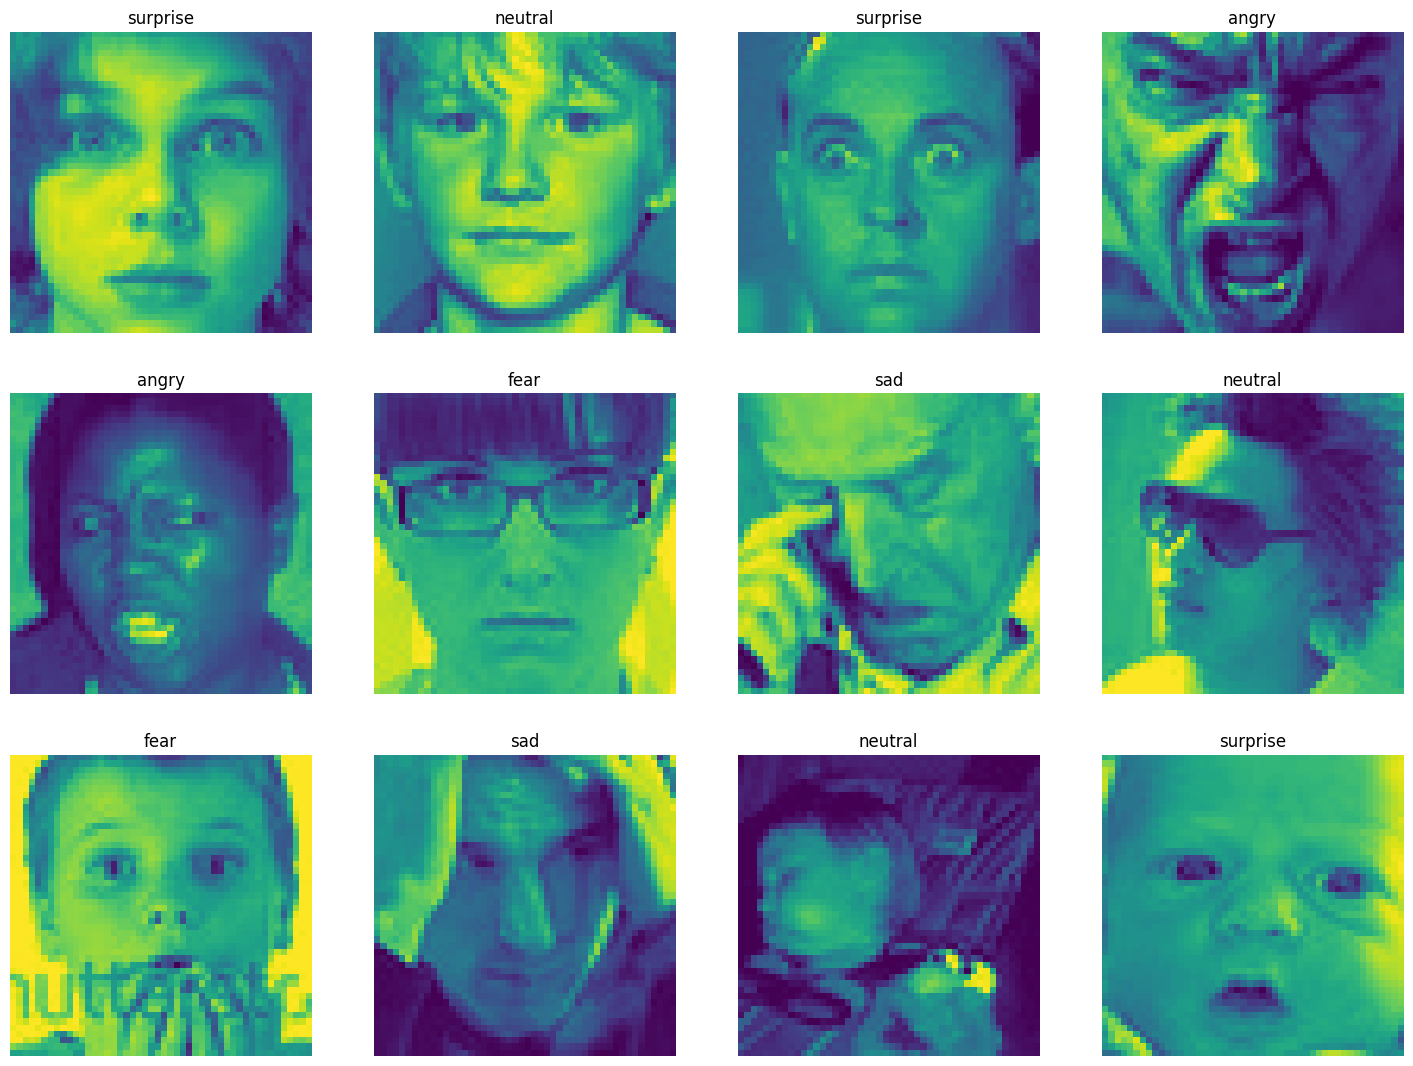

In [50]:
# Plot some images from the training dataset

plt.figure(figsize=(18, 18))

for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

In [51]:
#Checking class names
class_names = train_ds.class_names
print(class_names)


['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [52]:
label_to_text = {0: 'anger',1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [53]:
# Collect labels
labels_all = []

for _, labels in train_ds.take(50):   #limited batches
  labels_all.extend(labels.numpy())


In [54]:
# Creating a DataFrame
df = pd.DataFrame({
    'emotion': labels_all
})
df.shape


(1600, 1)

In [55]:
df.head(10)

,emotion
0,5
1,3
2,5
3,4
4,3
5,4
6,5
7,4
8,2
9,2


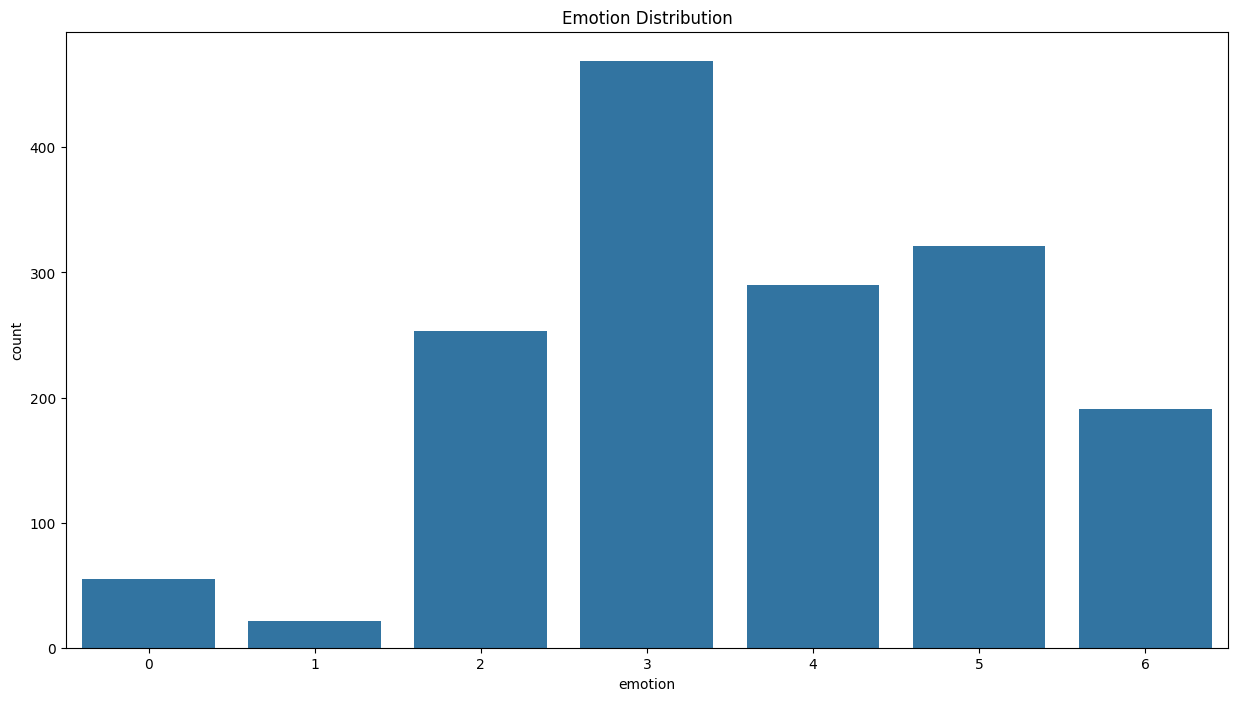

In [56]:
#  Plotting the above distribution
plt.figure(figsize=(15, 8))
sns.countplot(data=df, x='emotion')
plt.xlabel("emotion")
plt.ylabel("count")
plt.title("Emotion Distribution")
plt.show()


## Normalization

In [58]:
train_ds = train_ds.map(lambda x, y: (tf.cast(x, tf.float32)/255.0, y),
                        num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (tf.cast(x, tf.float32)/255.0, y),
                    num_parallel_calls=tf.data.AUTOTUNE)


In [59]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)


## Data Augmentation

In [60]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

## Model Architecture

In [61]:
model = Sequential([

    Input(shape=(48,48,1)),

    # Data Augmentation
    data_augmentation,

    # 1st Convolutional layer
    Conv2D(32, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    # 2nd Convolutional layer
    Conv2D(64, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    # 3rd Convolutional layer
    Conv2D(128, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    # Fully conected layer
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])


## Compile the model

In [62]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)       │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,275,271 (4.86 MB)

 Trainable params: 1,274,823 (4.86 MB)

 Non-trainable params: 448 (1.75 KB)

# Model Graph


In [63]:
!mkdir -p "/content/drive/MyDrive/Thesis Work - Facial Expression Detection & Recognition using Deep Learning"


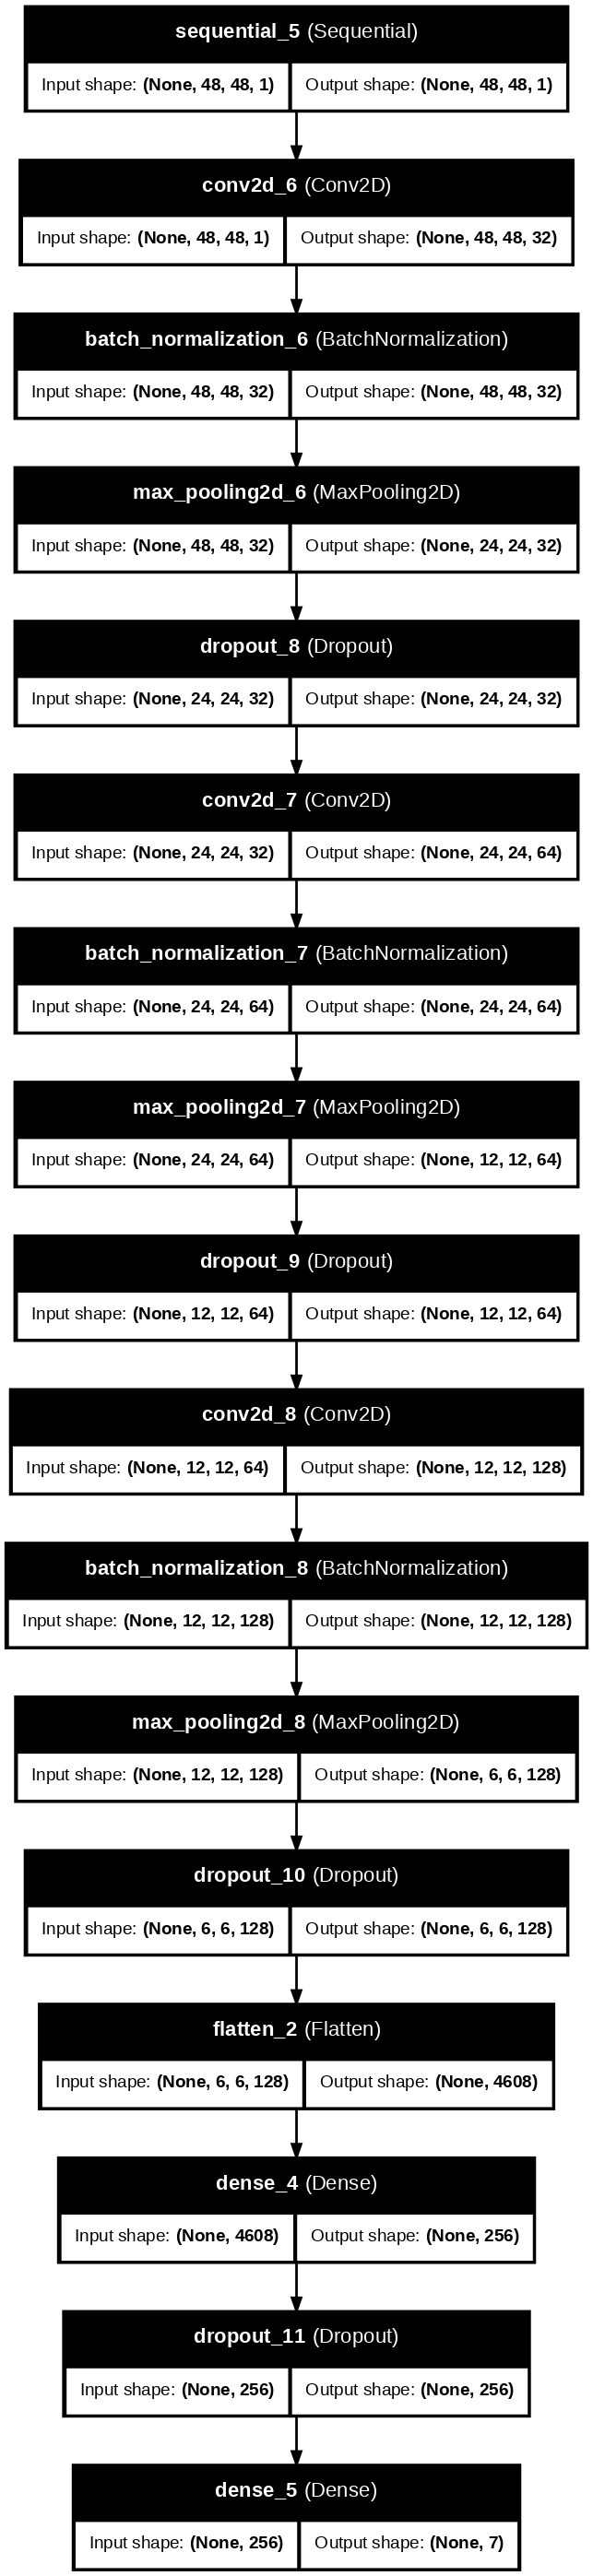

In [64]:
tf.keras.utils.plot_model(
    model,
    to_file="/content/drive/MyDrive/Thesis Work - Facial Expression Detection & Recognition using Deep Learning/best_model.png",
    show_shapes=True,
    show_layer_names=True,
    dpi=100
)


## Callback
Callbacks monitor the training process and take actions such as stopping training early to prevent overfitting and improve generalization.

In [65]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',          # watch validation loss
    patience=5,                  # wait 5 epochs before stopping
    restore_best_weights=True    # go back to best model
)


## Model Training

In [66]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop]
)


Epoch 1/30
643/643 ━━━━━━━━━━━━━━━━━━━━ 71s 106ms/step - accuracy: 0.2597 - loss: 2.1268 - val_accuracy: 0.2885 - val_loss: 1.7017
Epoch 2/30
643/643 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.2874 - loss: 1.7244 - val_accuracy: 0.3496 - val_loss: 1.5919
Epoch 3/30
643/643 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.3103 - loss: 1.6656 - val_accuracy: 0.4020 - val_loss: 1.5336
Epoch 4/30
643/643 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3294 - loss: 1.6221 - val_accuracy: 0.3794 - val_loss: 1.6961
Epoch 5/30
643/643 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.3613 - loss: 1.5803 - val_accuracy: 0.4481 - val_loss: 1.4532
Epoch 6/30
643/643 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.3819 - loss: 1.5389 - val_accuracy: 0.3887 - val_loss: 1.5575
Epoch 7/30
643/643 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.3850 - loss: 1.5319 - val_accuracy: 0.4528 - val_loss: 1.4294
Epoch 8/30
643/643 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3915 - loss: 1.5239 - val_

## Model Evaluation

In [67]:
# Training set evaluation
train_loss, train_acc = model.evaluate(train_ds, verbose=1)
print(f"✅ Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc*100:.2f}%")

# Validation / Test set evaluation
val_loss, val_acc = model.evaluate(val_ds, verbose=1)
print(f"✅ Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc*100:.2f}%")


643/643 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5861 - loss: 1.1531
✅ Training Loss: 1.1562, Training Accuracy: 58.36%
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5672 - loss: 1.2022
✅ Validation Loss: 1.1895, Validation Accuracy: 57.12%


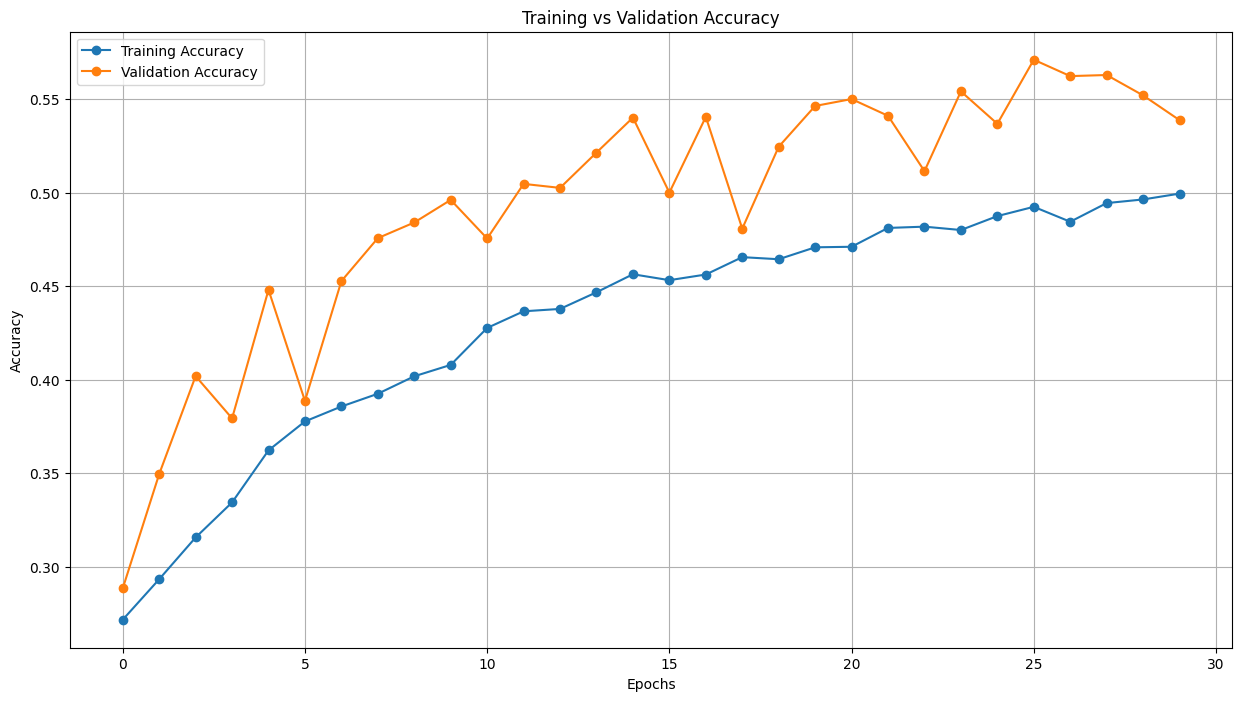

In [78]:
# Plot Accuracy
plt.figure(figsize=(15,8))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()



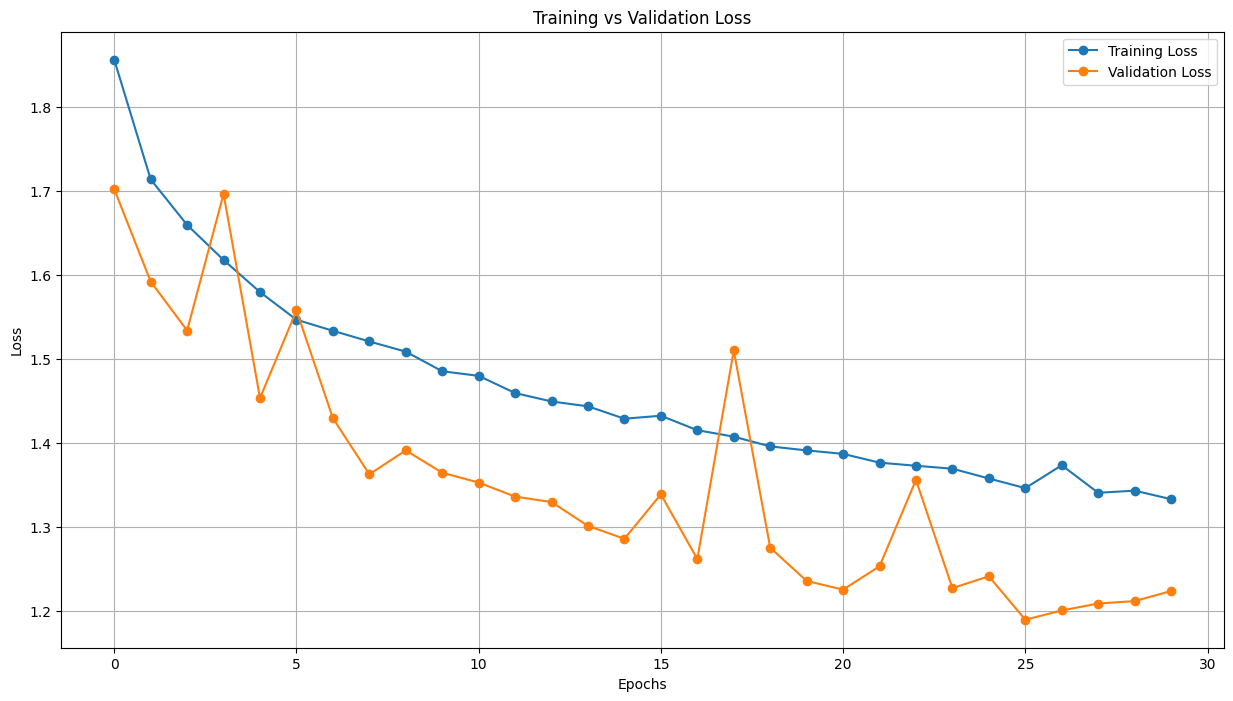

In [79]:
# Plot Loss
plt.figure(figsize=(15,8))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Confution Matrix

In [92]:
# Generate predictions on the validation set
val_predictions = model.predict(val_ds)
predicted_classes = np.argmax(val_predictions, axis=1)

# Get true labels from the validation set
true_classes = []
for _, labels in val_ds:
    true_classes.extend(labels.numpy())
true_classes = np.array(true_classes)


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


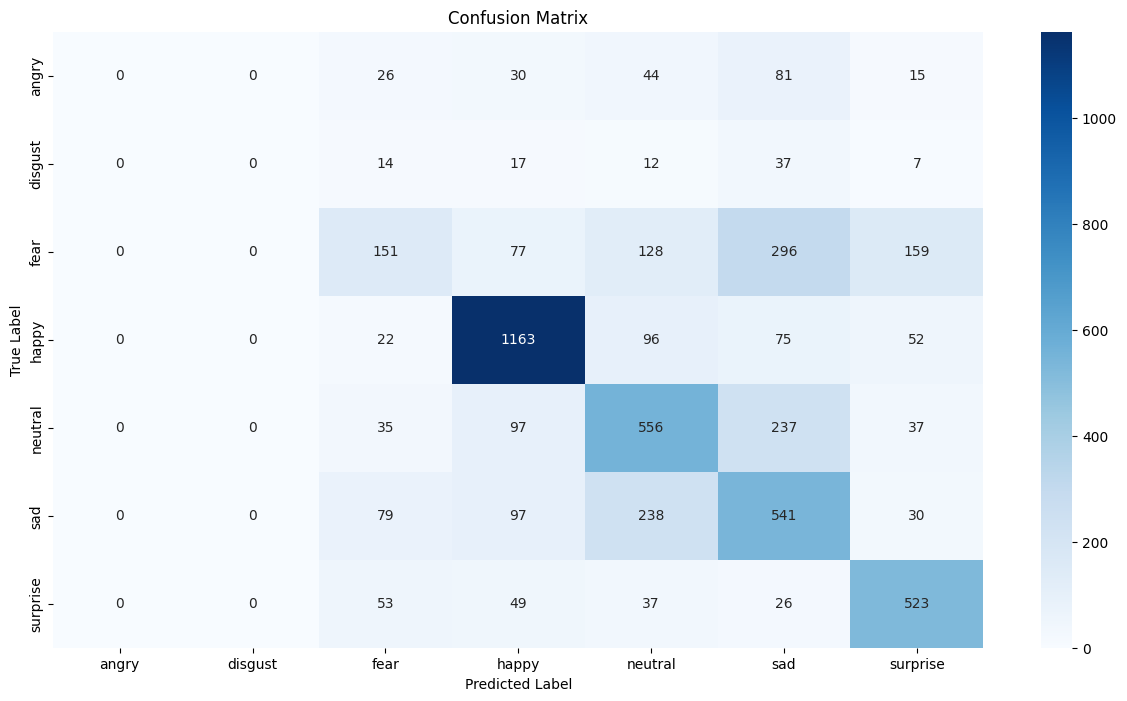

In [94]:
# confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(15, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Classification report

In [98]:
# the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_names)

print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       196
     disgust       0.00      0.00      0.00        87
        fear       0.40      0.19      0.25       811
       happy       0.76      0.83      0.79      1408
     neutral       0.50      0.58      0.54       962
         sad       0.42      0.55      0.47       985
    surprise       0.64      0.76      0.69       688

    accuracy                           0.57      5137
   macro avg       0.39      0.41      0.39      5137
weighted avg       0.53      0.57      0.54      5137



## Save Model

In [106]:
# Save the full model
model.save('model.h5')
print("model.h5'")


model.h5'
